In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
x_train= tf.cast(x_train, tf.float32)
x_test=tf.cast(x_test, tf.float32)

x_train = tf.image.resize(x_train[:], (10,10)).numpy()
x_test = tf.image.resize(x_test[:], (10,10)).numpy()

y_train = y_train[:]
y_test = y_test[:]

5


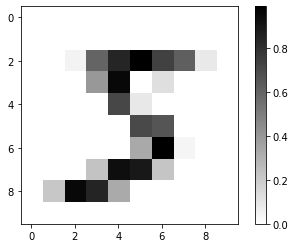

In [4]:
print(y_train[0])
fig = plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray_r')
plt.colorbar()
fig.savefig('sample', dpi=300)

# Fully Connected Layer Only

In [5]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

fc_model = models.Sequential()

fc_model.add(layers.Flatten(input_shape=(width,height,1)))
fc_model.add(layers.Dense(32, activation='relu'))
fc_model.add(layers.Dense(10, activation='softmax'))

In [6]:
fc_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fc_history = fc_model.fit(x_train, y_train, steps_per_epoch=500,
                        validation_data=(x_test, y_test), 
                        epochs=50, batch_size=5)

Epoch 1/50
500/500 [==============================] - 2s 5ms/step - loss: 1.6229 - accuracy: 0.5556 - val_loss: 1.0329 - val_accuracy: 0.7449
Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 0.8126 - accuracy: 0.7936 - val_loss: 0.6540 - val_accuracy: 0.8314
Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 0.6049 - accuracy: 0.8332 - val_loss: 0.5307 - val_accuracy: 0.8525
Epoch 4/50
500/500 [==============================] - 2s 4ms/step - loss: 0.5417 - accuracy: 0.8492 - val_loss: 0.4667 - val_accuracy: 0.8706
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 0.4684 - accuracy: 0.8680 - val_loss: 0.4353 - val_accuracy: 0.8770
Epoch 6/50
500/500 [==============================] - 2s 4ms/step - loss: 0.4218 - accuracy: 0.8824 - val_loss: 0.4007 - val_accuracy: 0.8856
Epoch 7/50
500/500 [==============================] - 2s 4ms/step - loss: 0.4353 - accuracy: 0.8728 - val_loss: 0.3942 - val_accuracy: 0.8834
Epoch 

# Convolutional Layer

In [7]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(width, height, 1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

In [8]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 8)           40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 648)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                20768     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 21,138
Trainable params: 21,138
Non-trainable params: 0
_________________________________________________________________


In [9]:
cnn_model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_history = cnn_model.fit(x_train, y_train, steps_per_epoch=500,
                        validation_data=(x_test, y_test), 
                        epochs=50, batch_size=5)

Epoch 1/50
500/500 [==============================] - 3s 5ms/step - loss: 1.0500 - accuracy: 0.7032 - val_loss: 0.5254 - val_accuracy: 0.8512
Epoch 2/50
500/500 [==============================] - 2s 5ms/step - loss: 0.5107 - accuracy: 0.8492 - val_loss: 0.4711 - val_accuracy: 0.8539
Epoch 3/50
500/500 [==============================] - 2s 5ms/step - loss: 0.4478 - accuracy: 0.8644 - val_loss: 0.3784 - val_accuracy: 0.8831
Epoch 4/50
500/500 [==============================] - 2s 5ms/step - loss: 0.3858 - accuracy: 0.8872 - val_loss: 0.3595 - val_accuracy: 0.8920
Epoch 5/50
500/500 [==============================] - 2s 5ms/step - loss: 0.3865 - accuracy: 0.8852 - val_loss: 0.3172 - val_accuracy: 0.9053
Epoch 6/50
500/500 [==============================] - 3s 5ms/step - loss: 0.3391 - accuracy: 0.8960 - val_loss: 0.3271 - val_accuracy: 0.8981
Epoch 7/50
500/500 [==============================] - 3s 5ms/step - loss: 0.3564 - accuracy: 0.8816 - val_loss: 0.2730 - val_accuracy: 0.9208
Epoch 

In [10]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 0.1393 - accuracy: 0.9570


# Make Quantum Convolution Layer

In [11]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, grid_size, qubits):
        for i in range(grid_size):
            for j in range(grid_size//2):
                yield cirq.CZPowGate(exponent=self._get_new_param(), global_shift=-0.5)(
                    qubits[grid_size*i+2*j+1], qubits[grid_size*i+2*j])
                yield cirq.CXPowGate(exponent=self._get_new_param(), global_shift=-0.5)(
                    qubits[grid_size*i+2*j+1], qubits[grid_size*i+2*j])
        for i in range(0, grid_size, 2):
            for j in range(grid_size//2):
                yield cirq.CZPowGate(exponent=self._get_new_param(), global_shift=-0.5)(
                    qubits[i+2*grid_size*j+grid_size], qubits[i+2*grid_size*j])
                yield cirq.CXPowGate(exponent=self._get_new_param(), global_shift=-0.5)(
                    qubits[i+2*grid_size*j+grid_size], qubits[i+2*grid_size*j])

    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        
        """
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        QCNN_circuit = cirq.Circuit()

        size_set = []
        next_size = self.filter_size
        while(True):
            if next_size == 1:
                break
            size_set.append(next_size)
            next_size //= 2
        input_params = [sympy.symbols('a%d' %i) for i in range(self.filter_size*self.filter_size)]

        input_circuit = cirq.Circuit()
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))

        for i, next_size in enumerate(size_set):
            next_qubits = self._next_qubit_set(self.filter_size, next_size, cirq_qubits)
            QCNN_circuit.append(self._QConv(next_size, next_qubits))

        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)

        self.circuit = full_circuit
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        
    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y] 
            
        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
          
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)
        

In [12]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

qcnn_model = models.Sequential()


qcnn_model.add(QConv(filter_size=2, depth=8, activation='relu', 
                     name='qconv1', input_shape=(width, height, 1)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
qcnn_model.add(layers.Dense(10, activation='softmax'))


In [13]:
qcnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
qconv1 (QConv)               (None, 9, 9, 8)           48        
_________________________________________________________________
flatten_2 (Flatten)          (None, 648)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                20768     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 21,146
Trainable params: 21,146
Non-trainable params: 0
_________________________________________________________________


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


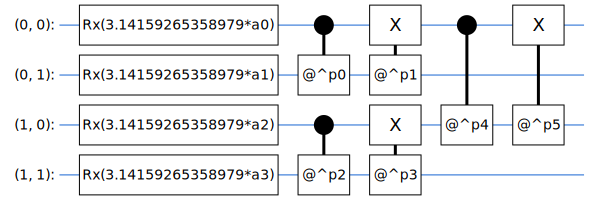

In [14]:
SVGCircuit(QConv(filter_size=2, depth=0, activation='relu').circuit)

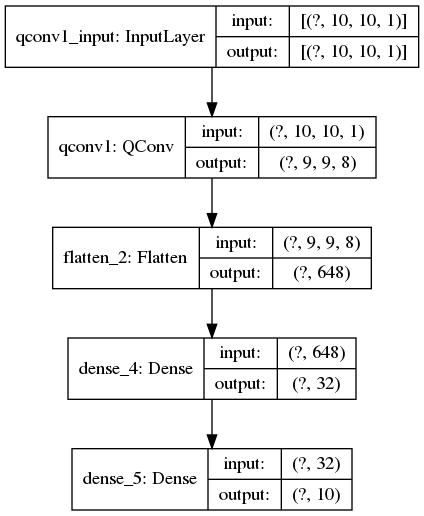

In [15]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(qcnn_model, to_file='model_shapes.png', show_shapes=True)

In [16]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train, steps_per_epoch=500,
                        validation_data=(x_test, y_test), 
                        epochs=50, batch_size=5)

Epoch 1/50
500/500 [==============================] - 323s 645ms/step - loss: 0.9971 - accuracy: 0.7172 - val_loss: 0.5769 - val_accuracy: 0.8336
Epoch 2/50
500/500 [==============================] - 328s 657ms/step - loss: 0.5242 - accuracy: 0.8436 - val_loss: 0.4749 - val_accuracy: 0.8618
Epoch 3/50
500/500 [==============================] - 301s 603ms/step - loss: 0.4328 - accuracy: 0.8720 - val_loss: 0.3819 - val_accuracy: 0.8893
Epoch 4/50
500/500 [==============================] - 302s 605ms/step - loss: 0.3766 - accuracy: 0.8816 - val_loss: 0.3329 - val_accuracy: 0.9011
Epoch 5/50
500/500 [==============================] - 301s 603ms/step - loss: 0.3460 - accuracy: 0.8936 - val_loss: 0.3193 - val_accuracy: 0.9050
Epoch 6/50
500/500 [==============================] - 280s 560ms/step - loss: 0.3203 - accuracy: 0.9020 - val_loss: 0.2845 - val_accuracy: 0.9138
Epoch 7/50
500/500 [==============================] - 278s 557ms/step - loss: 0.3522 - accuracy: 0.8996 - val_loss: 0.2743 -

In [17]:
test_loss, test_acc = qcnn_model.evaluate(x_test, y_test, verbose=2)

313/313 - 179s - loss: 0.1522 - accuracy: 0.9532


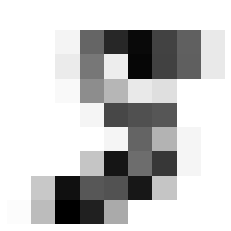

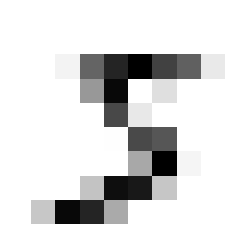

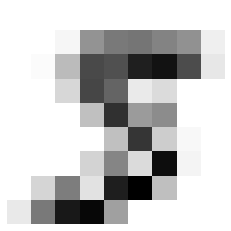

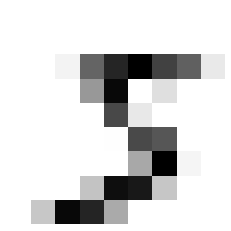

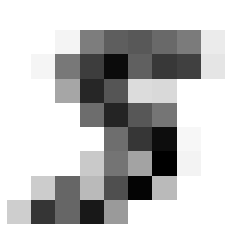

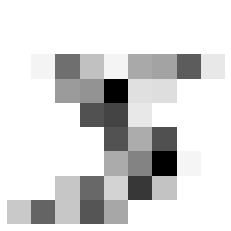

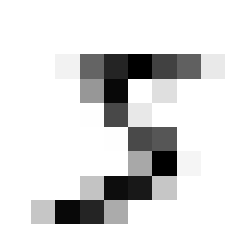

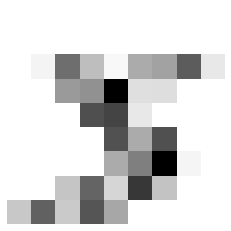

In [18]:
for i in range(8):
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(qcnn_model.get_layer('qconv1')(x_train[0:1,:,:,:])[0,:,:,i], cmap='gray_r')
    fig.savefig('qcnn_%d'%i, dpi=300, bbox_inches='tight')

# Comparing Result

In [19]:
def plot_loss_curves(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss)) + 1, fc_loss, "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_loss)) + 1, cnn_loss, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss)) + 1, qcnn_loss, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss.png', dpi=300)
    
def plot_loss_curves_small(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss))[::2] + 1, fc_loss[::2], "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_loss))[::2] + 1, cnn_loss[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss))[::2] + 1, qcnn_loss[::2], "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set loss")
    plt.grid(True)
    fig.savefig('loss_small.png', dpi=300)

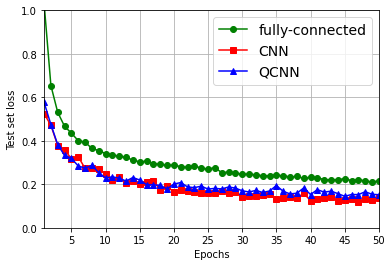

In [20]:
plot_loss_curves(fc_history.history['val_loss'], cnn_history.history['val_loss'], qcnn_history.history['val_loss'])

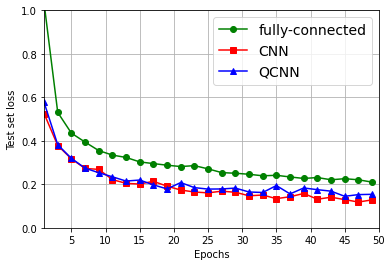

In [21]:
plot_loss_curves_small(fc_history.history['val_loss'], cnn_history.history['val_loss'], qcnn_history.history['val_loss'])

In [22]:
def plot_acc_curves(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc)) + 1, fc_acc, "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_acc)) + 1, cnn_acc, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc)) + 1, qcnn_acc, "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0.8, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy.png', dpi=300)
    
def plot_acc_curves_small(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc))[::2] + 1, fc_acc[::2], "go-", label="fully-connected")
    plt.plot(np.arange(len(cnn_acc))[::2] + 1, cnn_acc[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc))[::2] + 1, qcnn_acc[::2], "b^-", label="QCNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 50, 0.8, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Test set accuracy")
    fig.savefig('accuracy_small.png', dpi=300)

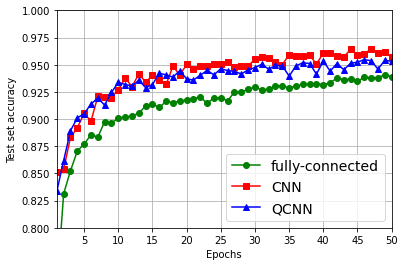

In [23]:
plot_acc_curves(fc_history.history['val_accuracy'], cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])

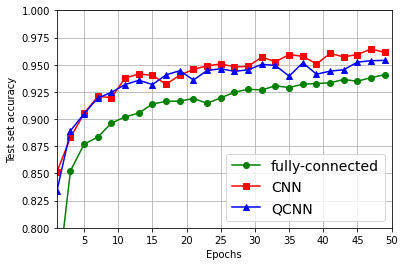

In [24]:
plot_acc_curves_small(fc_history.history['val_accuracy'], cnn_history.history['val_accuracy'], qcnn_history.history['val_accuracy'])